# Introduction to Trackintel

This tutorial will give you an overview of the most important functionalities of Trackintel.

- the data model used in Trackintel 
- importing data to Trackintel
- preprocessing tracking data through the hierarchy
- labeling tracking data
- analyzing tracking data

To get started, we import Trackintel and other necessary libraries.



In [1]:
import os

import trackintel as ti
import geopandas as gpd
import pandas as pd
from IPython import display
import folium
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def date2str(df):
    """transform dates into strings for plotting"""
    
    df = df.copy()
    col_names = ['tracked_at', 'started_at', 'finished_at']
    for col_name in col_names:
        if col_name in df.columns:
            df[col_name] = df[col_name].dt.strftime('%Y-%m-%d %X')
    return df

## Data import using Geopandas

As a first step, any data that we want to use with trackintel has to be loaded as trackintel class. For some data sources, trackintel has specific [data loaders](https://trackintel.readthedocs.io/en/latest/modules/io.html#predefined-dataset-readers) but most of the time you will have to manually load the data. 

The standard way to load data into trackintel is to create a geopandas dataframe first and then transform it into trackintel. We now load a standard geojson file that contains trackpoints of a person.

In [3]:
# we read geojson files using geopandas function
gdf = gpd.read_file('../Data/pfs_tutorial.geojson')
gdf.head(5)

,id,lat,lon,elevation,time,User,accuracy,geometry
0,0,39.984702,116.318417,149.9616,2008-10-23 02:53:04+00:00,0,None,POINT (116.31842 39.98470)
1,1,39.984683,116.318450,149.9616,2008-10-23 02:53:10+00:00,0,None,POINT (116.31845 39.98468)
2,2,39.984686,116.318417,149.9616,2008-10-23 02:53:15+00:00,0,None,POINT (116.31842 39.98469)
3,3,39.984688,116.318385,149.9616,2008-10-23 02:53:20+00:00,0,None,POINT (116.31839 39.98469)
4,4,39.984655,116.318263,149.9616,2008-10-23 02:53:25+00:00,0,None,POINT (116.31826 39.98465)


### Load GeoDataFrame into Trackintel
The next step is to load the GeoDataFrame as an object of the Trackintel Positionfix class. The Trackintel classes have some specific requirements on column names. 

For positionfixes these are: 
| **Positionfix** |
|-----------------|
| user_id         |
| geometry        |
| tracked_at    

The GeoDataFrame can hold arbitrary additional columns. To be able to use the GeoDataFrame for Trackintel, we will have to rename some of the columns. For this, Trackintel offers a helper function [positionfixes_from_gpd](https://trackintel.readthedocs.io/en/latest/modules/io.html#geodataframe-import). The helper function is used to rename the columns and to define a timezone. The index is assumed to be the unique identifier of the rows.

In [4]:
pfs = ti.io.read_positionfixes_gpd(gdf, tracked_at="time", user_id="User", geom_col="geometry", tz='UTC')
print(type(pfs), '\n\n')
      
display.display(pfs)


<class 'trackintel.model.positionfixes.Positionfixes'> 




,id,lat,lon,elevation,tracked_at,user_id,accuracy,geometry
0,0,39.984702,116.318417,149.9616,2008-10-23 02:53:04+00:00,0,None,POINT (116.31842 39.98470)
1,1,39.984683,116.318450,149.9616,2008-10-23 02:53:10+00:00,0,None,POINT (116.31845 39.98468)
2,2,39.984686,116.318417,149.9616,2008-10-23 02:53:15+00:00,0,None,POINT (116.31842 39.98469)
3,3,39.984688,116.318385,149.9616,2008-10-23 02:53:20+00:00,0,None,POINT (116.31839 39.98469)
4,4,39.984655,116.318263,149.9616,2008-10-23 02:53:25+00:00,0,None,POINT (116.31826 39.98465)
...,...,...,...,...,...,...,...,...
4236,4236,39.977904,116.327067,99.9744,2008-10-24 06:35:35+00:00,1,None,POINT (116.32707 39.97790)
4237,4237,39.977907,116.327066,99.9744,2008-10-24 06:35:40+00:00,1,None,POINT (116.32707 39.97791)
4238,4238,39.977900,116.327064,99.9744,2008-10-24 06:35:45+00:00,1,None,POINT (116.32706 39.97790)
4239,4239,39.977900,116.327064,99.9744,2008-10-24 06:35:48+00:00,1,None,POINT (116.32706 39.97790)


`pfs` is now a Trackintel class and has access to all Trackintel functions. For example, they can be visualized with the plot function.


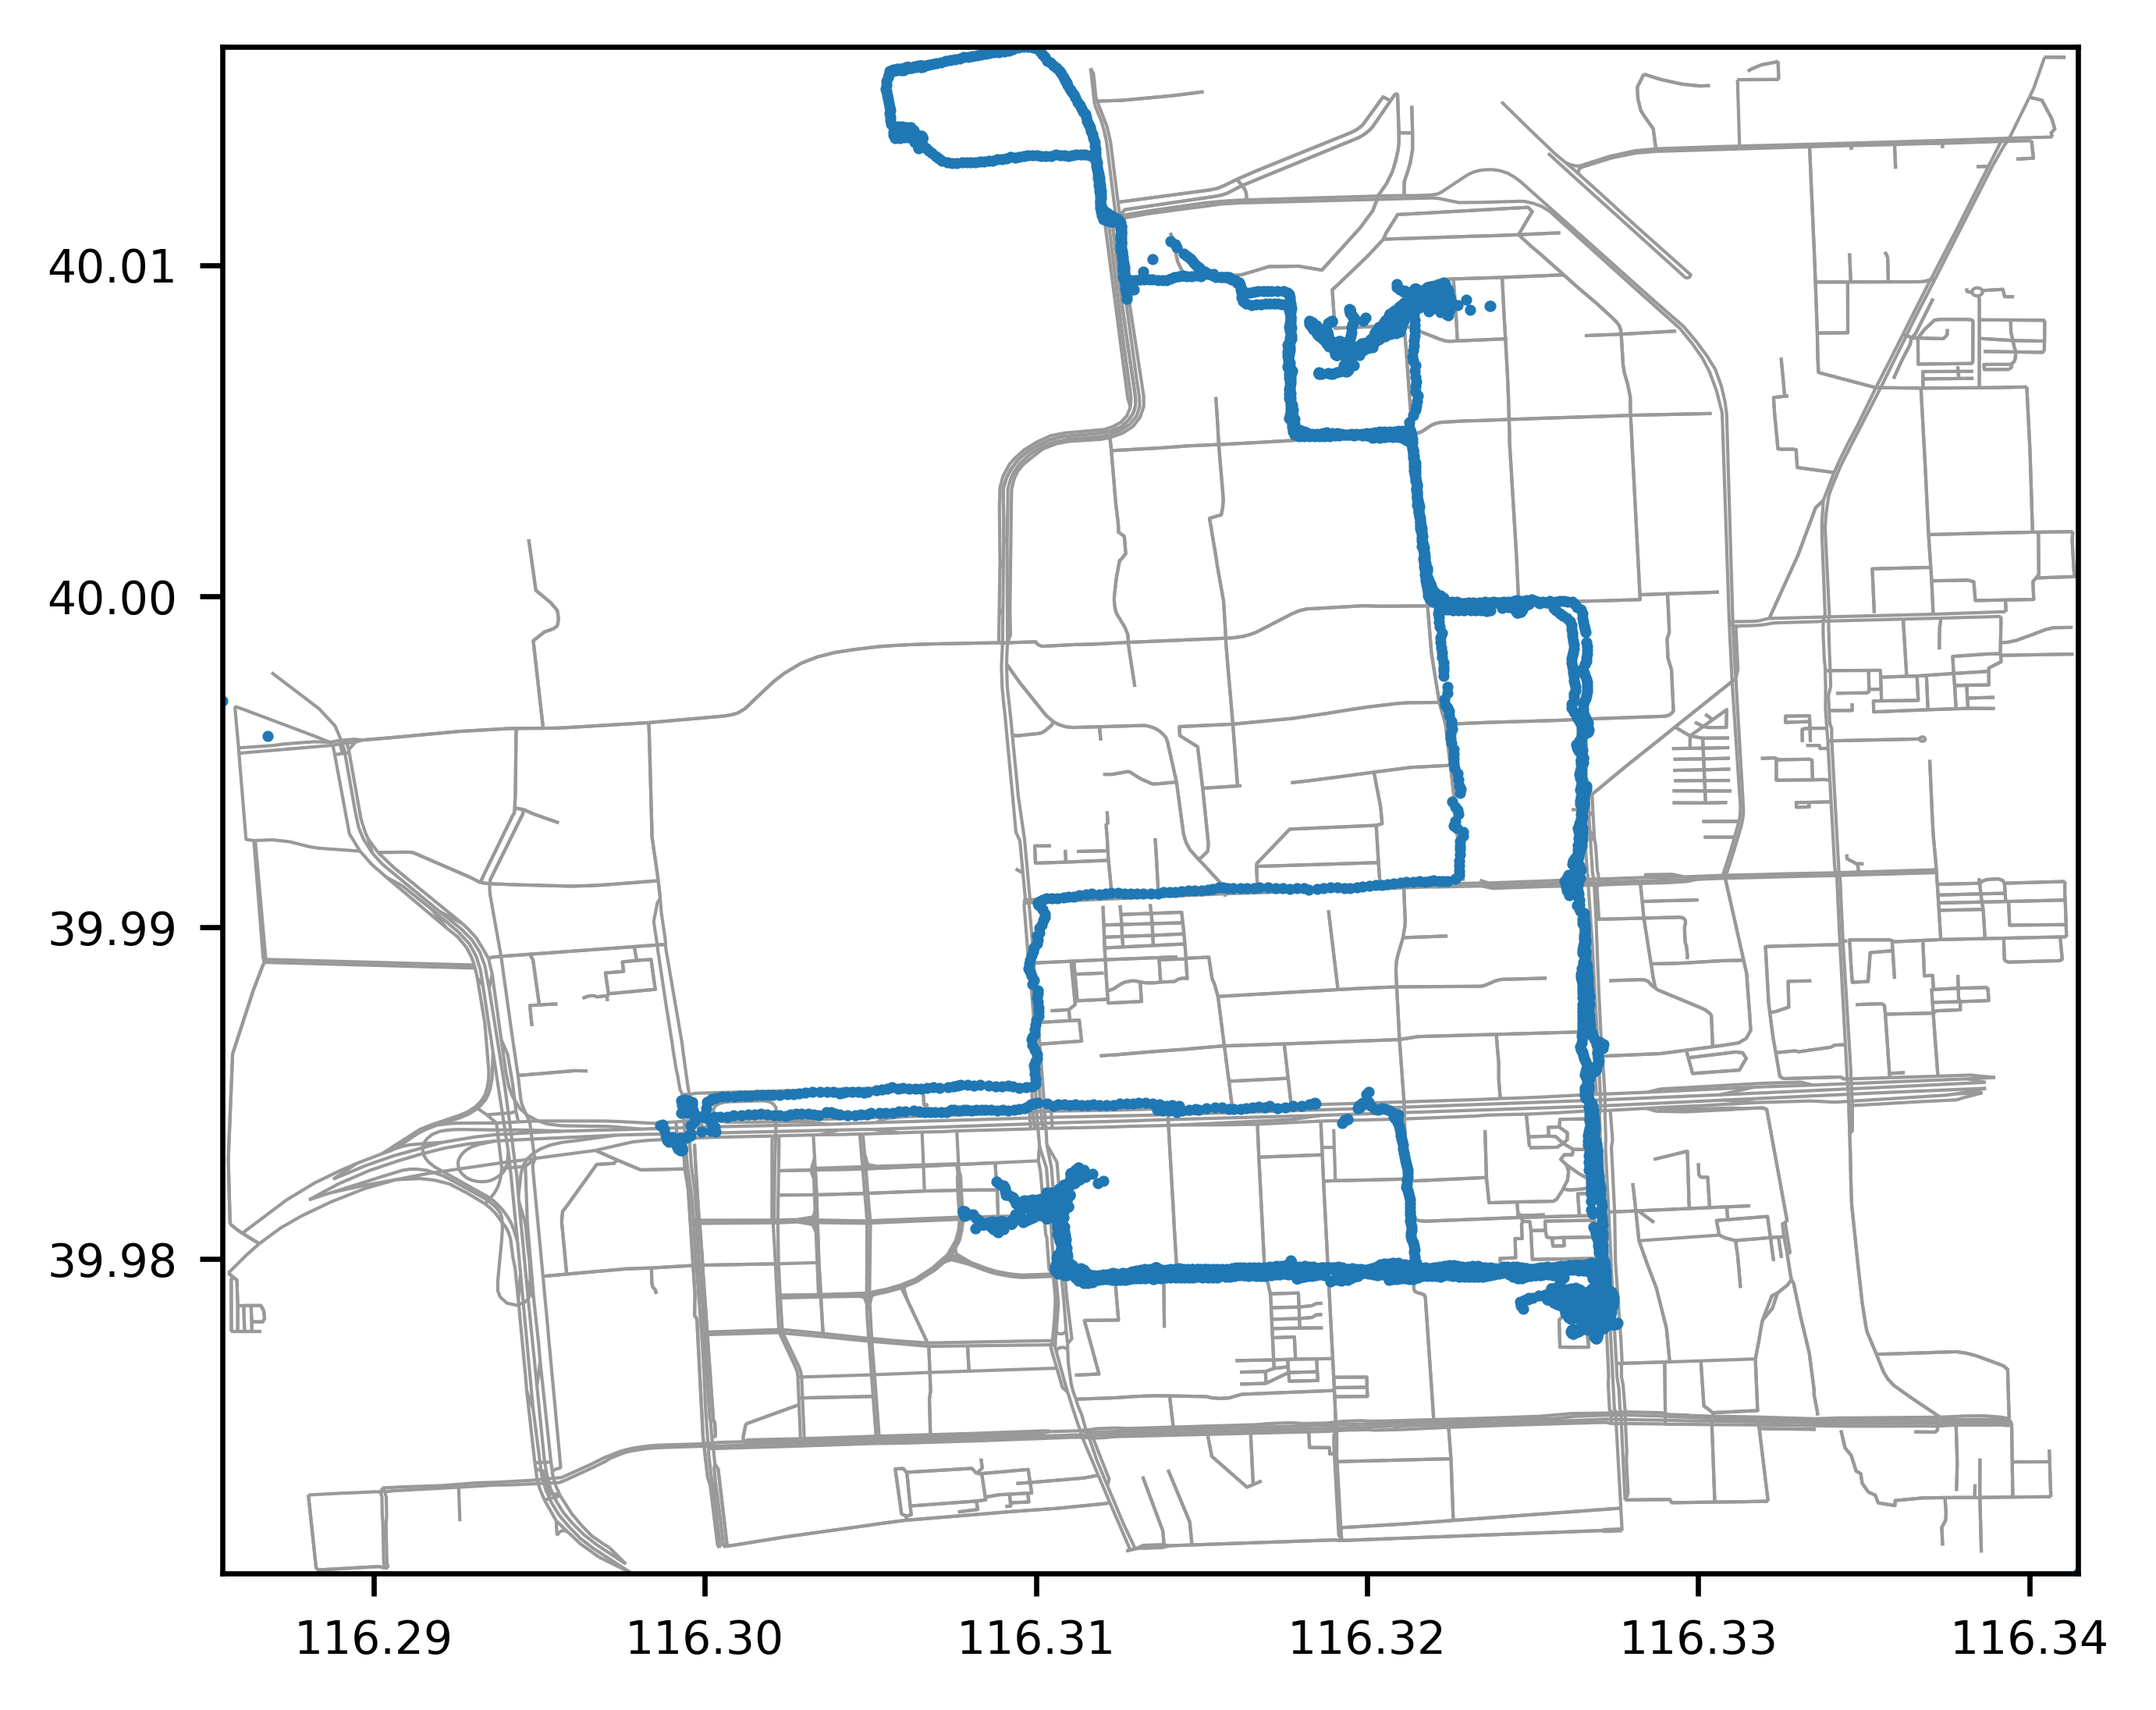

In [5]:
ti.plot(pfs, plot_osm=True) 

# Import the Geolife dataset using the data loader

For some popular datasets, Trackintel offers a dedicated dataloader that takes care of all data reading and transformation steps and greatly facilitates working with the dataset.


The [Geolife dataset](https://www.microsoft.com/en-us/research/publication/geolife-gps-trajectory-dataset-user-guide/) is a collection of GPS trajectory data from 182 users, covering over 1.2 million kilometers and diverse transport modes, primarily collected between 2007 and 2012. It is widely used in research for studying human mobility, traffic patterns, and urban planning. It was collected by Microsoft Research.

We have created a subset of the Geolife dataset that is available in `\Data\Geolife`. The Geolife dataset as it is downloaded uses a very particular custom data structure that requires a lot of effort to properly read. Luckily we can simply use the `read_geolife` function from Trackintel.


In [6]:
pfs, _ = ti.io.dataset_reader.read_geolife('../Data/Geolife/Data', print_progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


In [7]:
date2str(pfs[0:2000]).explore()

# Basic data segmentation

The Geolife dataset is based on GPS trackpoints (called positionfixes); however, these usually do not carry semantics as movement and staying are mixed. To further analyze and interpret the data, Trackintel supports the segmentation into movement and stationary behavior and the aggregation of both following the Trackintel data model. 
<center>
    <img src="../Data/hierarchy.png" alt="hierarchy" width="400"/>
</center>

### Staypoints

In [8]:

pfs, sp = pfs.generate_staypoints(method='sliding', dist_threshold=100, time_threshold=5.0, include_last=False, print_progress=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:39<00:00,  1.99s/it]


In [9]:
display.display(sp.head())
display.display(pfs[pfs['staypoint_id'] == 1])

,user_id,started_at,finished_at,elevation,geom
id,,,,,
0,1,2008-10-23 11:03:41+00:00,2008-10-23 11:09:05+00:00,37.1856,POINT (116.30623 40.01595)
1,1,2008-10-24 00:14:40+00:00,2008-10-24 00:21:04+00:00,62.7888,POINT (116.32510 39.97884)
2,1,2008-10-24 03:26:30+00:00,2008-10-24 03:50:05+00:00,49.9872,POINT (116.31354 39.97959)
3,1,2008-10-24 03:56:21+00:00,2008-10-24 04:08:59+00:00,75.5904,POINT (116.32579 39.97870)
4,1,2008-10-24 06:11:07+00:00,2008-10-24 06:23:12+00:00,104.0892,POINT (116.31055 39.98160)


,elevation,tracked_at,geom,user_id,accuracy,staypoint_id
id,,,,,,
2981157,92.6592,2008-10-24 00:14:40+00:00,POINT (116.32471 39.97848),1,NaN,1
2981158,89.6112,2008-10-24 00:14:41+00:00,POINT (116.32463 39.97858),1,NaN,1
2981159,92.0496,2008-10-24 00:14:43+00:00,POINT (116.32462 39.97870),1,NaN,1
2981160,77.4192,2008-10-24 00:14:45+00:00,POINT (116.32475 39.97875),1,NaN,1
2981161,66.4464,2008-10-24 00:14:47+00:00,POINT (116.32484 39.97878),1,NaN,1
2981162,63.0936,2008-10-24 00:14:52+00:00,POINT (116.32488 39.97881),1,NaN,1
2981163,62.7888,2008-10-24 00:14:57+00:00,POINT (116.32501 39.97883),1,NaN,1
2981164,62.7888,2008-10-24 00:15:00+00:00,POINT (116.32517 39.97890),1,NaN,1
2981165,61.2648,2008-10-24 00:20:39+00:00,POINT (116.32548 39.97896),1,NaN,1


### Triplegs

In [10]:
%%time
pfs, tpls = pfs.generate_triplegs(sp, method='between_staypoints', gap_threshold=15)

CPU times: user 1min 1s, sys: 1.75 s, total: 1min 3s
Wall time: 1min 3s


In [11]:
print("positionfixes")
display.display(pfs[0:500])
print("triplegs")
display.display(tpls)


positionfixes


,elevation,tracked_at,geom,user_id,accuracy,staypoint_id,tripleg_id
id,,,,,,,
3044109,149.9616,2008-10-23 05:53:05+00:00,POINT (116.31924 39.98409),1,NaN,<NA>,0
3044110,149.9616,2008-10-23 05:53:06+00:00,POINT (116.31932 39.98420),1,NaN,<NA>,0
3044111,149.9616,2008-10-23 05:53:11+00:00,POINT (116.31940 39.98422),1,NaN,<NA>,0
3044112,149.9616,2008-10-23 05:53:16+00:00,POINT (116.31939 39.98421),1,NaN,<NA>,0
3044113,149.6568,2008-10-23 05:53:21+00:00,POINT (116.31942 39.98422),1,NaN,<NA>,0
...,...,...,...,...,...,...,...
3044604,41.4528,2008-10-23 10:53:12+00:00,POINT (116.31769 40.00587),1,NaN,<NA>,1
3044605,42.3672,2008-10-23 10:53:16+00:00,POINT (116.31768 40.00599),1,NaN,<NA>,1
3044606,38.4048,2008-10-23 10:53:20+00:00,POINT (116.31768 40.00612),1,NaN,<NA>,1


triplegs


,user_id,started_at,finished_at,geom
id,,,,
0,1,2008-10-23 05:53:05+00:00,2008-10-23 06:01:57+00:00,"LINESTRING (116.31924 39.98409, 116.31932 39.9..."
1,1,2008-10-23 10:32:53+00:00,2008-10-23 11:03:36+00:00,"LINESTRING (116.34145 39.97051, 116.32693 39.9..."
2,1,2008-10-23 11:09:05+00:00,2008-10-23 11:10:29+00:00,"LINESTRING (116.30549 40.01555, 116.30549 40.0..."
3,1,2008-10-23 11:49:08+00:00,2008-10-23 12:04:28+00:00,"LINESTRING (116.30649 40.01354, 116.30645 40.0..."
4,1,2008-10-23 23:41:04+00:00,2008-10-24 00:13:20+00:00,"LINESTRING (116.30647 40.01387, 116.30649 40.0..."
...,...,...,...,...
10291,169,2010-06-02 10:21:51+00:00,2010-06-02 10:41:05+00:00,"LINESTRING (116.32732 39.97774, 116.32731 39.9..."
10292,169,2010-06-03 00:52:03+00:00,2010-06-03 01:24:12+00:00,"LINESTRING (116.39965 40.05327, 116.39968 40.0..."
10293,169,2010-06-03 10:10:03+00:00,2010-06-03 10:31:55+00:00,"LINESTRING (116.33010 39.97591, 116.32992 39.9..."


### Labeling activities

To create trips, we need to distinguish between activity staypoints and non-activity staypoint (e.g., waiting at a bus station would not be an activity). This can be done based on a time threshold with the trackintel function `create_activity_flag`.

In [12]:
sp = sp.as_staypoints.create_activity_flag(method="time_threshold", time_threshold=25)
sp.head()

,user_id,started_at,finished_at,elevation,geom,is_activity
id,,,,,,
0,1,2008-10-23 11:03:41+00:00,2008-10-23 11:09:05+00:00,37.1856,POINT (116.30623 40.01595),False
1,1,2008-10-24 00:14:40+00:00,2008-10-24 00:21:04+00:00,62.7888,POINT (116.32510 39.97884),False
2,1,2008-10-24 03:26:30+00:00,2008-10-24 03:50:05+00:00,49.9872,POINT (116.31354 39.97959),False
3,1,2008-10-24 03:56:21+00:00,2008-10-24 04:08:59+00:00,75.5904,POINT (116.32579 39.97870),False
4,1,2008-10-24 06:11:07+00:00,2008-10-24 06:23:12+00:00,104.0892,POINT (116.31055 39.98160),False


### Aggregating movement data to trips

Trips summarize all movement and all non-significant stays between two activities. They represent the main unit of interest in the activity-based movement analysis common in transport behaviour studies.

In [13]:
sp, tpls, trips = ti.preprocessing.triplegs.generate_trips(staypoints=sp, triplegs=tpls, gap_threshold=15, add_geometry=True)

### A short look at trips

We now combine triplegs and staypoints in a single dataframe in order to have a look at the ID management.

In [14]:
sp['type'] = 'Staypoint'
tpls['type'] = 'Tripleg'

sp_tpls = pd.concat([sp[['started_at', 'finished_at', 'user_id', 'type', 'is_activity', 'prev_trip_id', 'next_trip_id', 'trip_id']],
                     tpls[['started_at', 'finished_at', 'user_id', 'type', 'trip_id']]]).sort_values(['user_id', 'started_at'])

Some points to pay attention:
- The first staypoints are not long enough to qualify as an activity and are therefore part of trip 63
- There is a tracking data gap between trip 63 and 64; therefore, a new trip is started
- There is an activity between trips 64 and 65

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
        display.display(sp_tpls.iloc[170:181])


,started_at,finished_at,user_id,type,is_activity,prev_trip_id,next_trip_id,trip_id
id,,,,,,,,
62,2008-11-04 23:44:36+00:00,2008-11-04 23:56:04+00:00,1,Staypoint,False,<NA>,<NA>,63
110,2008-11-04 23:56:04+00:00,2008-11-05 00:02:46+00:00,1,Tripleg,NaN,<NA>,<NA>,63
63,2008-11-05 00:02:51+00:00,2008-11-05 00:07:58+00:00,1,Staypoint,False,<NA>,<NA>,63
111,2008-11-05 00:07:58+00:00,2008-11-05 00:15:06+00:00,1,Tripleg,NaN,<NA>,<NA>,63
64,2008-11-05 00:15:09+00:00,2008-11-05 00:20:26+00:00,1,Staypoint,False,<NA>,<NA>,63
112,2008-11-05 00:20:26+00:00,2008-11-05 00:42:44+00:00,1,Tripleg,NaN,<NA>,<NA>,63
113,2008-11-05 11:00:52+00:00,2008-11-05 11:13:11+00:00,1,Tripleg,NaN,<NA>,<NA>,64
65,2008-11-05 11:13:16+00:00,2008-11-05 11:51:53+00:00,1,Staypoint,True,64,65,<NA>
114,2008-11-05 11:51:53+00:00,2008-11-05 12:03:20+00:00,1,Tripleg,NaN,<NA>,<NA>,65


## Extracting important locations using clustering

People mostly visit the same locations again and again. These important locations can be represented in the `Location` class in Trackintel and can be extracted using clustering. Trackintel again connects staypoints and locations via IDs.

In [16]:
sp, locs = ti.preprocessing.generate_locations(
        sp, epsilon=30, num_samples=2,
        distance_metric="haversine",
        print_progress=True, n_jobs=4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.27it/s]


In [17]:
m = folium.Map([39.99848, 116.32521], width=600, height=400, zoom_start=16)

sp_u1 = sp[sp['user_id']==1]
locs_u1 = locs[locs['user_id']==1]

m = date2str(sp_u1).explore(m=m)
m = locs_u1.explore(marker_type='circle', marker_kwds={'radius':30}, m=m)
m

# Analysis
The [analysis module](https://trackintel.readthedocs.io/en/latest/modules/analysis.html) in Trackintel focuses on the semantic enrichment and quantitative analysis of human movement data. As an example, we provide labeling functions to infer semantic labels of staypoints and triplegs.

### Analysis of activity purposes
Activities drive our mobility. It is therefore of interest to analyze in greater detail for what purpose we spend our time. Trackintel has implemented different algorithms from [1] to identify home and work locations. 


[1] Chen, Qingqing, and Ate Poorthuis. 2021. ‘Identifying Home Locations in Human Mobility Data: An Open-Source R Package for Comparison and Reproducibility’. International Journal of Geographical Information Science 0 (0): 1–24. https://doi.org/10.1080/13658816.2021.1887489.

In [18]:
sp["purpose"] = ti.analysis.location_identifier(sp, pre_filter=False)["purpose"]
sp[['purpose']].groupby('purpose').size()

purpose
home    1310
work     399
dtype: int64

This can be used to further analyze the time spend at home/work locations and compare it to other datasets as it was done in the Trackintel case study that is [available online](https://github.com/mie-lab/trackintel/blob/master/examples/Trackintel_case_study.pdf). 

<center>
    <img src="../Data/fraction_home_staypoints.png" alt="hierarchy" width="400"/>
</center>

### Analysis of transport mode

In [19]:
# infer transport mode based on speed 
tpls = tpls.predict_transport_mode()

# the result is the original tripleg with a column 'mode'
tpls.head(5)

,finished_at,geom,started_at,user_id,trip_id,type,mode
id,,,,,,,
0,2008-10-23 06:01:57+00:00,"LINESTRING (116.31924 39.98409, 116.31932 39.9...",2008-10-23 05:53:05+00:00,1,0,Tripleg,slow_mobility
1,2008-10-23 11:03:36+00:00,"LINESTRING (116.34145 39.97051, 116.32693 39.9...",2008-10-23 10:32:53+00:00,1,1,Tripleg,slow_mobility
2,2008-10-23 11:10:29+00:00,"LINESTRING (116.30549 40.01555, 116.30549 40.0...",2008-10-23 11:09:05+00:00,1,1,Tripleg,slow_mobility
3,2008-10-23 12:04:28+00:00,"LINESTRING (116.30649 40.01354, 116.30645 40.0...",2008-10-23 11:49:08+00:00,1,2,Tripleg,slow_mobility
4,2008-10-24 00:13:20+00:00,"LINESTRING (116.30647 40.01387, 116.30649 40.0...",2008-10-23 23:41:04+00:00,1,3,Tripleg,slow_mobility


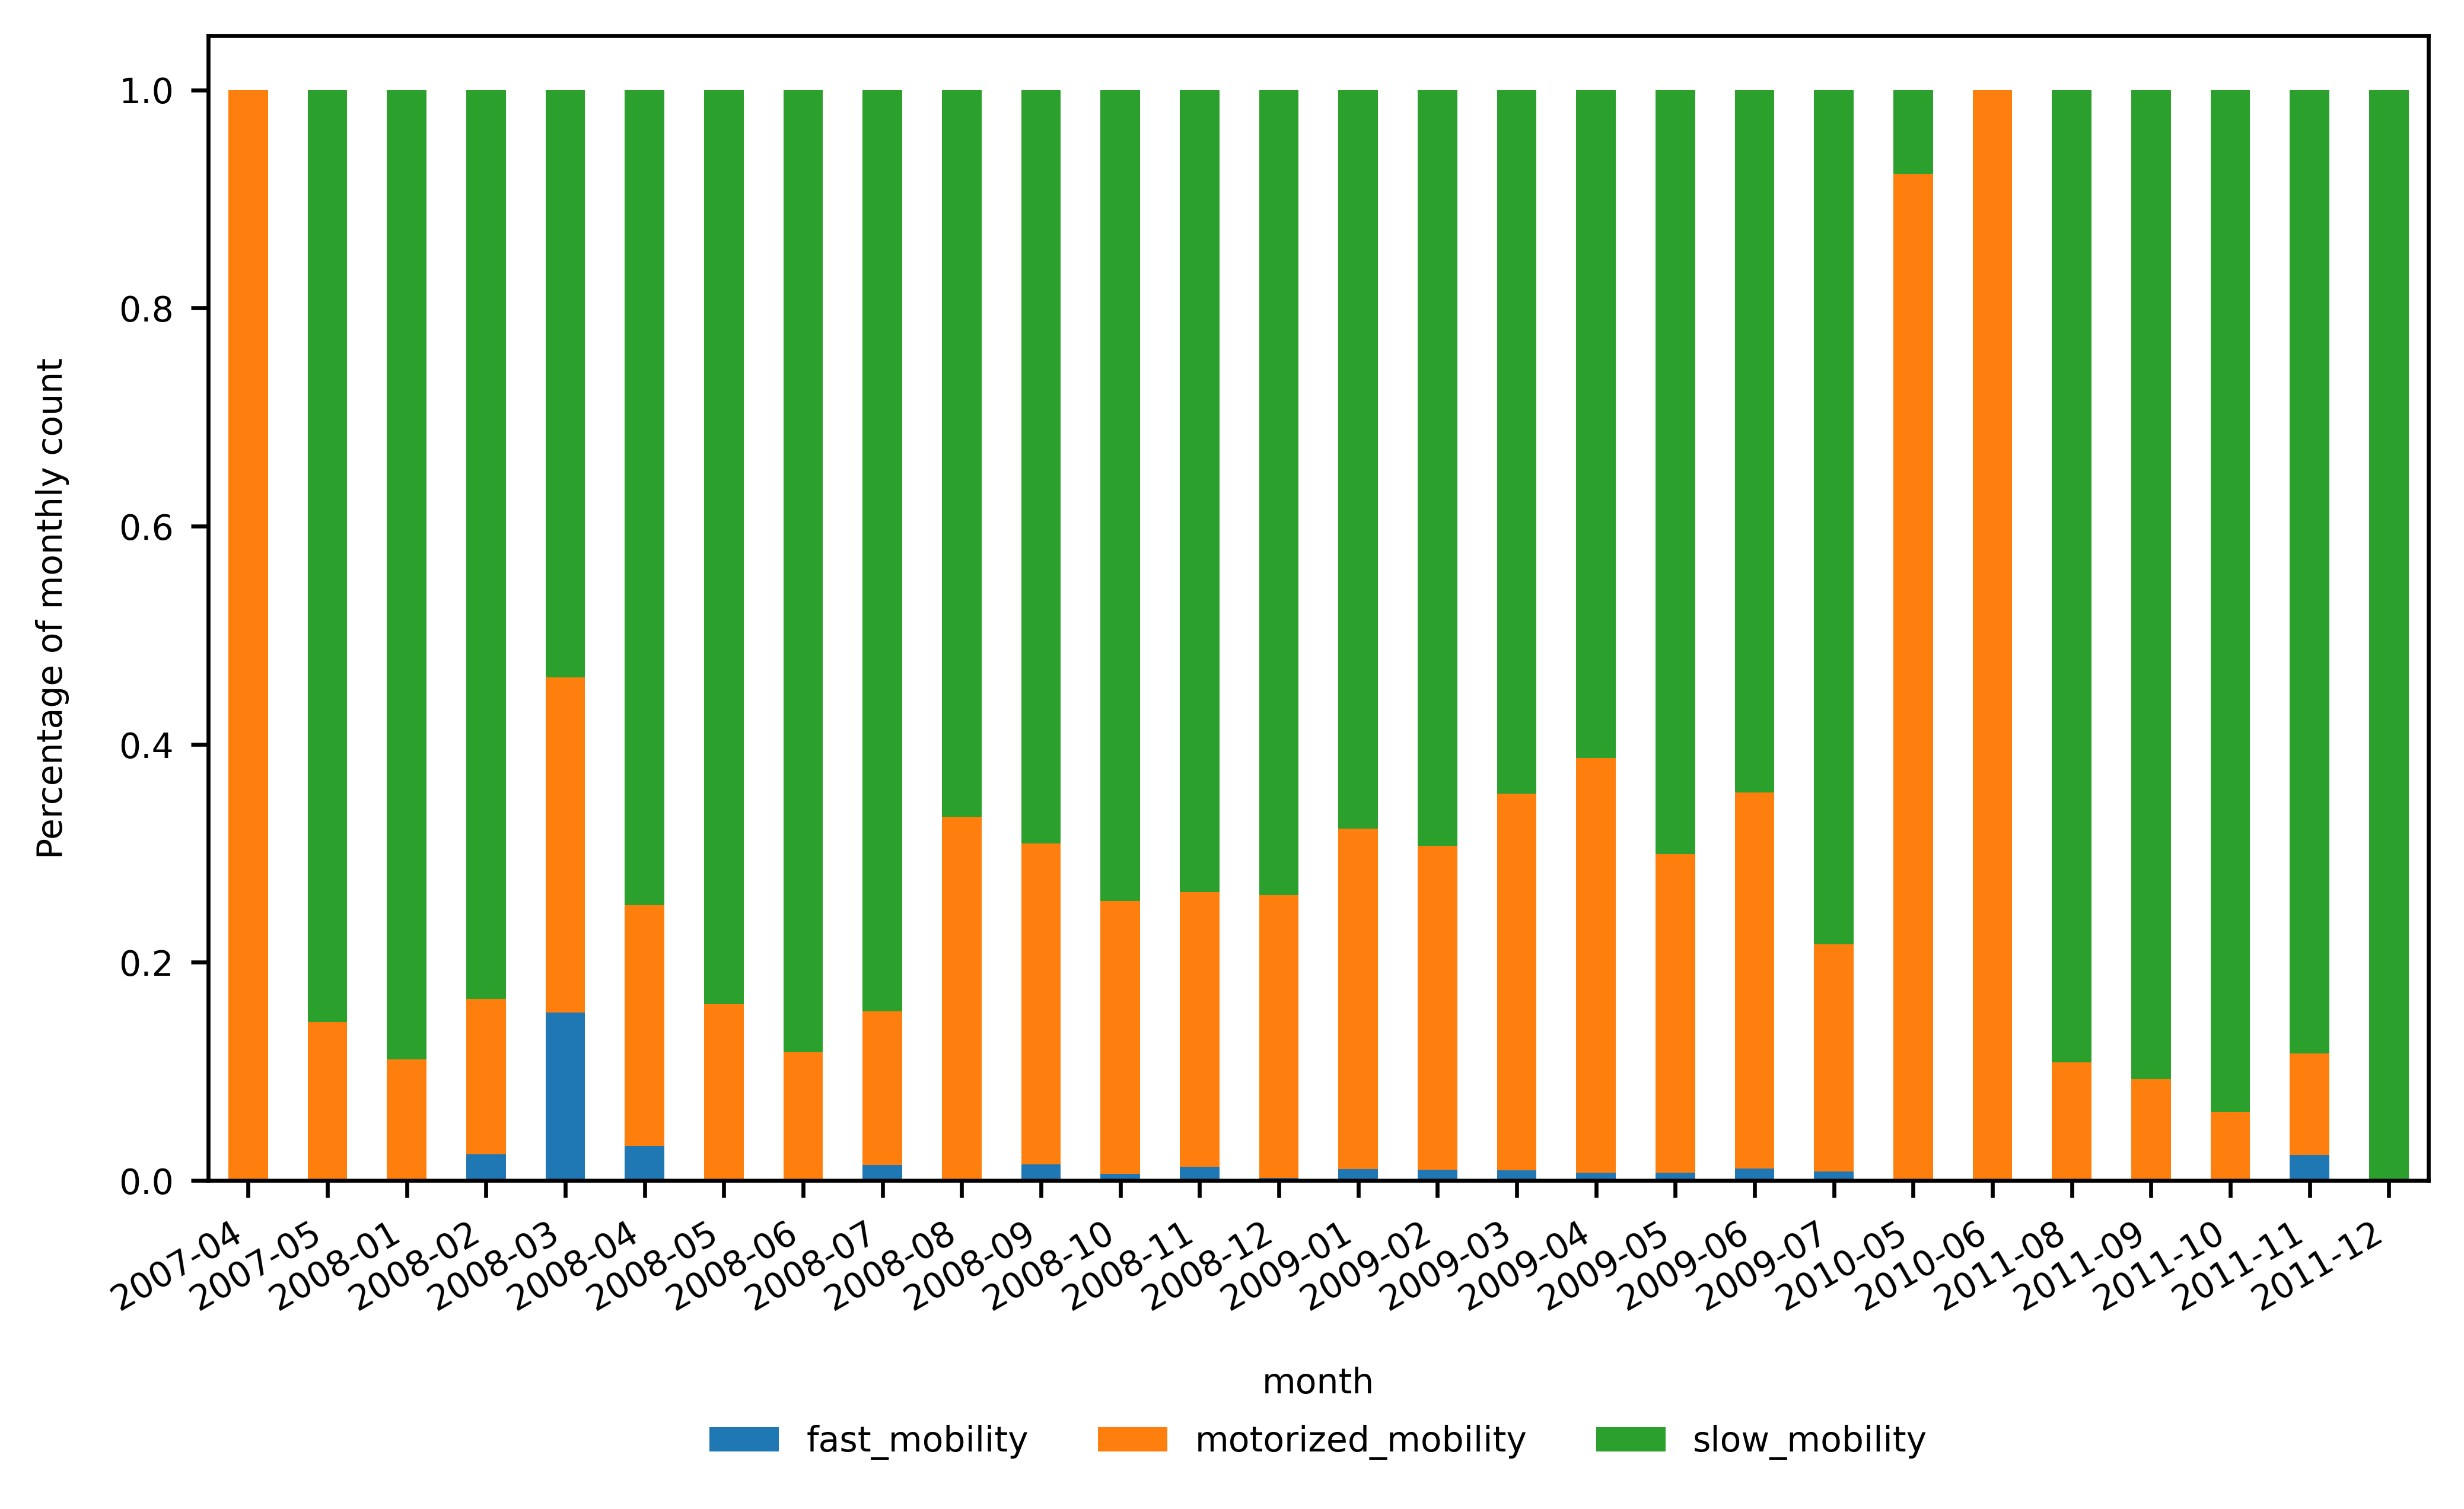

In [20]:
# the modal split can then be calculated
modal_split = ti.analysis.calculate_modal_split(tpls, metric="count", freq="M", per_user=False, norm=True)

# and visualized
ti.plot_modal_split(modal_split, date_fmt_x_axis='%Y-%m', y_label='Percentage of monthly count', x_label='month', x_pad=10, borderaxespad=5)
plt.show()

# Save results
The generated data can be exported as csv files using [`write_XXX_csv()` functions](https://trackintel.readthedocs.io/en/latest/modules/io.html#csv-file-export) registered to each Trackintel class (e.g. `write_positionfixes_csv`). For each function in the visualization module, we provide an `filename` parameter to directly save the figures as a file.

In [21]:
os.makedirs("out", exist_ok=True)

# save datamodels to csv files
ti.io.write_positionfixes_csv(pfs[0:1000], os.path.join('out', 'pfs_tutorial.csv'))
ti.io.write_staypoints_csv(sp[0:1000], os.path.join('out', 'sp_tutorial.csv'))
ti.io.write_triplegs_csv(tpls[0:1000], os.path.join('out', 'tpls_tutorial.csv'))
ti.io.write_trips_csv(trips, os.path.join('out', 'trips_tutorial.csv'))

# filename will save the generated plot as a file
ti.plot(filename='./out/pfs.png', positionfixes=pfs[0:1000], plot_osm=True)

For database users, we provide functions and instructions to support the import and export from PostGIS databases. Further information can be found in the [trackintel documentation](https://trackintel.readthedocs.io/en/latest/). 

Thanks for using Trackintel. If you discover any bug and/or have an idea for a useful funcionality feel free to open an [issue](https://github.com/mie-lab/trackintel/issues) or to contribute with a pull request!